# DATA 512 Project Analysis

## Social and Economic Impact of COVID 19 in San Mateo County, CA

The following analysis takes into account the covid confirmed cases and deaths along with information regarding the masking mandates, percentage of vaccines being administered , housing rate and unemployment rates to further analysis the social and economic impact on the people of San Mateo. 



In [23]:
# Loading all the libraries that would be required for this analysis

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as datetime
import ruptures as rpt
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt 
%matplotlib inline
from scipy.stats import ttest_ind

## Step 0: Data Acquisition

1. **The RAW_us_confirmed_cases.csv** file from the Kaggle repository of [John Hopkins University COVID-19 data](https://www.kaggle.com/datasets/antgoldbloom/covid19-data-from-john-hopkins-university). 
2. **The CDC dataset** of [masking mandates by county](https://data.cdc.gov/Policy-Surveillance/U-S-State-and-Territorial-Public-Mask-Mandates-Fro/62d6-pm5i). Note that the CDC stopped collecting this policy information in September 2021.
3. **The New York Times** [mask compliance survey](https://github.com/nytimes/covid-19-data/tree/master/mask-use) data. 
4. **Confirmed deaths** from the Kaggle repository of [John Hopkins University COVID-19 data](https://www.kaggle.com/datasets/antgoldbloom/covid19-data-from-john-hopkins-university). 
5. **San Mateo masking mandate** - This data is collected by reading the announcements posted by the San Mateo officials on [smsgoc.org](https://www.smcgov.org/san-mateo-county-reopening) 
6. **Percentage of single dose vaccines** being administered - This data is also collected by monitoring the state's official dashboard for vaccines being administered at [smchealth.org](https://www.smchealth.org/post/vaccination-totals-locations-data)
7. **Housing Rate** - This dataset contains the median listing price in a given market during the specified month for San Mateo County. Using this dataset we can analyze the economic effect due to the pandemic.
8. **Unemployment Rate** - This dataset can be used to answer the economic effect of the pandemic to see if it was affected and by how much during different stages of the pandemic.

### US County Assigned: San Mateo, CA

In [24]:
# Loading all the quantitative datasets into dataframes

confirmed_cases = pd.read_csv('RAW_us_confirmed_cases.csv')
masking_mandate = pd.read_csv('cdc_masking_mandates_county.csv')
mask_use = pd.read_csv('mask-use-by-county.csv')
confirmed_deaths = pd.read_csv('RAW_us_deaths.csv')
unemp_rate = pd.read_csv('unemployment_sanmat.csv')
housing_price = pd.read_csv('housing_price.csv')

*NOTE: Qualitative data like dates of vaccines being administered and the dates for San Mateo masking mandates are taken from the articles and replicated on the visualizations directly*

## Step 1: Data Prep

## Data Cleaning and Standardization

### 1. For the confirmed cases per county

In [25]:
# Creating a sub-data frame which has the data of the desired county only
# Province_State = California and Admin2 = San Mateo

county_cases = confirmed_cases[(confirmed_cases["Province_State"] == "California") & 
                               (confirmed_cases["Admin2"] == "San Mateo")]

#Viewing the dataframe to understand it better
county_cases

,Province_State,Admin2,UID,iso2,iso3,code3,FIPS,Country_Region,Lat,Long_,...,10/22/22,10/23/22,10/24/22,10/25/22,10/26/22,10/27/22,10/28/22,10/29/22,10/30/22,10/31/22
238,California,San Mateo,84006081,US,USA,840,6081.0,US,37.422881,-122.327555,...,180152,180152,180152,180609,180609,180610,180611,180611,180611,180611


We see the FIPS score will be needed for accessing the mask_use dataframe, hence storing that value is a variable called 'san_mateo_FIPS'

In [26]:
san_mateo_FIPS = county_cases['FIPS'].values[0]
san_mateo_FIPS

6081.0

Looking at all the column names in county_cases, not all of them are useful/needed. Thus we create a new dataframe to just keep only the relevant date columns.
Columns 21 onwards is from Feb 01, 2020.

In [27]:
county_cases_bydate = county_cases[county_cases.columns[21:]]
county_cases_bydate = pd.DataFrame(county_cases_bydate.iloc[0])
county_cases_bydate = county_cases_bydate.reset_index()
county_cases_bydate.columns = ["date", "confirmed_cases"]

Converting the 'date' column to 'datetime' type so that we can use *filter* to get the desired subset of the desired date range. i.e., February 1, 2020 through October 1, 2021

In [28]:
county_cases_bydate['date'] = pd.to_datetime(county_cases_bydate['date'])
county_cases_bydate = county_cases_bydate.loc[(county_cases_bydate['date'] <= '2021-10-01')]

After creating the dataframe, we want to check if there are any missing values before proceeding onto cleaning the other dataframes.

In [29]:
county_cases_bydate.isna().sum()

date               0
confirmed_cases    0
dtype: int64

Windowing the data to **weekly** to smoothen the noise and interpret better.

In [30]:
county_cases_bydate['confirmed_cases'] = county_cases_bydate['confirmed_cases'].rolling(7).mean()
county_cases_bydate = county_cases_bydate.fillna(0)

Confirmed cases is to be the cumulative number of cases confirmed. Thus daily confirmed cases will be a a delta change thus clculating the gradient of the cases to get daily confirmed cases.

In [31]:
county_cases_bydate["confirmed_cases"] = pd.Series(np.gradient(county_cases_bydate["confirmed_cases"]), 
                                             county_cases_bydate["date"], name='confirmed_cases').values
# Taking the absolute as there are very few places where the delta change is 
# negative and this could be an issue of data entry.

county_cases_bydate["confirmed_cases"] = county_cases_bydate["confirmed_cases"].abs()

county_cases_df = county_cases_bydate
# For the purpoe of time series analysis, converting the dataframe into a series
# With date set as the index
county_cases_bydate = county_cases_bydate.set_index('date') 
county_cases_bydate

,confirmed_cases
date,
2020-02-01,0.000000
2020-02-02,0.000000
2020-02-03,0.000000
2020-02-04,0.000000
2020-02-05,0.000000
...,...
2021-09-27,68.500000
2021-09-28,70.000000
2021-09-29,71.071429


### 2. For masking mandate per county dataframe

In [32]:
# Creating a 'm_mandate_county' dataframe to store the respectove data for San Mateo, CA

m_mandate_county = masking_mandate[(masking_mandate["County_Name"] == "San Mateo County") & 
                               (masking_mandate["State_Tribe_Territory"] == "CA")]

In [33]:
m_mandate_county.head()

,State_Tribe_Territory,County_Name,FIPS_State,FIPS_County,date,order_code,Face_Masks_Required_in_Public,Source_of_Action,URL,Citation
60116,CA,San Mateo County,6,81,4/10/2020,2,NaN,NaN,NaN,NaN
60117,CA,San Mateo County,6,81,4/11/2020,2,NaN,NaN,NaN,NaN
60118,CA,San Mateo County,6,81,4/12/2020,2,NaN,NaN,NaN,NaN
60119,CA,San Mateo County,6,81,4/13/2020,2,NaN,NaN,NaN,NaN
60120,CA,San Mateo County,6,81,4/14/2020,2,NaN,NaN,NaN,NaN


Looking are the dataframe we can see that the columns of interest for us would be "date" and "Face_Masks_Required_in_Public"

In [34]:
m_mandate_county = m_mandate_county.filter(['date', 'Face_Masks_Required_in_Public'], axis = 1)

# Checking for the kinds of values present in the dataframe
m_mandate_county.Face_Masks_Required_in_Public.unique()

array([nan, 'Yes'], dtype=object)

As we can see, NAN can be replaced with "No" as there is no other option int he dataframe other than 'Yes' and 'NAN'

In [35]:
m_mandate_county["Face_Masks_Required_in_Public"] = m_mandate_county["Face_Masks_Required_in_Public"].fillna("No")

# Converting date as string to date-time format
# To be able to set it as an index
m_mandate_county['date'] = pd.to_datetime(m_mandate_county['date'])
m_mandate_county = m_mandate_county.set_index('date')
m_mandate_county

,Face_Masks_Required_in_Public
date,
2020-04-10,No
2020-04-11,No
2020-04-12,No
2020-04-13,No
2020-04-14,No
...,...
2021-08-11,Yes
2021-08-12,Yes
2021-08-13,Yes


### 3. For mask compliance survey data

Saving the data for San Mateo by using the FIPS value we saved earlier in step 1 to a new data frame called 'mask_survey'

In [36]:
mask_survey = mask_use[mask_use['COUNTYFP'] == int(san_mateo_FIPS)]

# viewing the dataframe
mask_survey

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
226,6081,0.016,0.013,0.058,0.126,0.786


### 4. For COVID deaths data

In [37]:
sm_ca_deaths = confirmed_deaths[(confirmed_deaths["Province_State"] == "California") & 
                               (confirmed_deaths["Admin2"] == "San Mateo")]

#Viewing the dataframe to understand it better
sm_ca_deaths

,Province_State,Admin2,UID,iso2,iso3,code3,FIPS,Country_Region,Lat,Long_,...,10/30/22,10/31/22,11/1/22,11/2/22,11/3/22,11/4/22,11/5/22,11/6/22,11/7/22,11/8/22
238,California,San Mateo,84006081,US,USA,840,6081.0,US,37.422881,-122.327555,...,841,841,841,841,843,843,843,843,843,843


Looking at the above table, we can see that wee need to transform the table to a data frame with just the required columns. Hence selecting the columns of interest.

In [38]:
sm_ca_deaths = sm_ca_deaths[sm_ca_deaths.columns[22:]]
sm_ca_deaths = pd.DataFrame(sm_ca_deaths.iloc[0])
sm_ca_deaths = sm_ca_deaths.reset_index()
sm_ca_deaths.columns = ["date", "death_cases"]

In [39]:
# creating a dataframe to save these as a series
df_series_deaths = sm_ca_deaths
df_series_deaths['date'] = pd.to_datetime(df_series_deaths['date'])
df_series_deaths = df_series_deaths.loc[(df_series_deaths['date'] <= '2021-10-01')]

In [42]:
# Converting one copy to series for time-series analysis
df_series_deaths = df_series_deaths.set_index('date') 

df_series_deaths.head()

,death_cases
date,
2020-02-01,0
2020-02-02,0
2020-02-03,0
2020-02-04,0
2020-02-05,0


For further analysis, we retain a copy of the COVID deaths beyng Oct 01, 2021 and collect it until Nov 2022 to better understand the effect of vaccines. 

In [44]:
df_deaths = sm_ca_deaths
df_deaths['date'] = pd.to_datetime(df_deaths['date'])
df_deaths = df_deaths.set_index('date') 

### 5. For housing rates data

For conducting t-tets, we will need two groups of data where there is data of the housing rates before pandemic and after pandemic. Therefore we create two dataframes with "post" being 01 Feb 2020 to 01 Oct 2021 and "pre" being 01 May 2018 to 01 Jan 2020.

In [49]:
housing_price = housing_price.rename(columns={'DATE': 'date', 'MEDLISPRIMM6081': 'h_rate'})
housing_price['date'] = pd.to_datetime(housing_price['date'])
housing_price_post = housing_price.loc[(housing_price['date'] <= '2021-10-01') & (housing_price['date'] >= '2020-02-01')]
housing_price_pre = housing_price.loc[(housing_price['date'] <= '2020-01-01') & (housing_price['date'] >= '2018-05-01')]

### 6. For unemployment data

For conducting t-tets, we will need two groups of data where there is data of the unemployment rates before pandemic and after pandemic. Therefore we create two dataframes with "post" being 01 Feb 2020 to 01 Oct 2021 and "pre" being 01 May 2018 to 01 Jan 2020.

In [48]:
unemp_rate = unemp_rate.rename(columns={'DATE': 'date', 'CASANM0URN': 'u_rate'})
unemp_rate['date'] = pd.to_datetime(unemp_rate['date'])
unemp_rate_post = unemp_rate.loc[(unemp_rate['date'] <= '2021-10-01') & (unemp_rate['date'] >= '2020-02-01')]
unemp_rate_pre = unemp_rate.loc[(unemp_rate['date'] <= '2020-01-01') & (unemp_rate['date'] >= '2018-05-01')]

## Step 2: Analyze and Visualize

In this step we want you to answer our research questions and hypothesis. 

We analyze the foloowing questions: -
1. Common Analysis: How did masking policies change the progression of confirmed COVID-19 cases from February 1, 2020 through October 1, 2021?
2. Extension Analysis: What other trends can the masking mandate by the San Mateo County reveal about the pandemic?
3. With every stage of vaccines administered, is there a decrease in the number of deaths caused by COVID?
4. Hypothesis: There is no relationship between the median listing prices of houses and the number of
confirmed COVID cases in San Mateo County. 
5. How was the unemployment rate affected in San Mateo County due to the pandemic?

## 1. Common Analysis: How did masking policies change the progression of confirmed COVID-19 cases from February 1, 2020 through October 1, 2021?

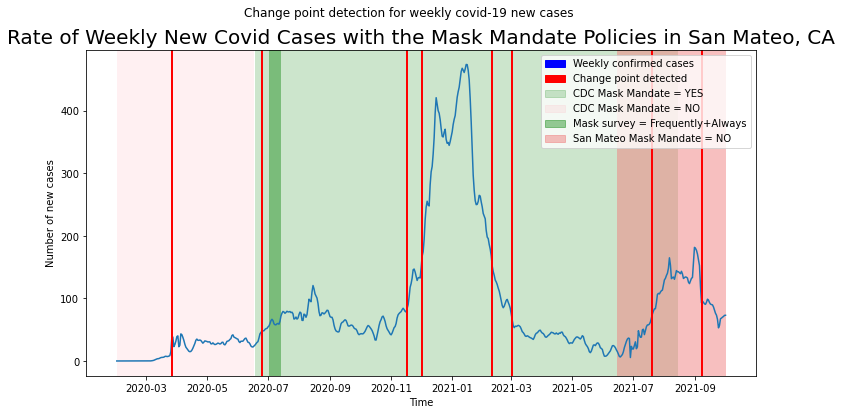

In [229]:
# Using the ruptures package for detecting change point
# Pelt Search Method

data = np.array(county_cases_bydate)
algo = rpt.Pelt(model="rbf").fit(data)

change_locations = algo.predict(pen=10)
change_locations = county_cases_bydate.iloc[change_locations[:-1]].index.to_list()

plt.figure(figsize=(12,6))
plt.plot(county_cases_bydate)

# Plotting red horizontal lines for days when a change point is detected
for i in change_locations:
    plt.axvline(i,lw=2, color='red')
    
red_patch = mpatches.Patch(color='red', label='Change point detected')
blue_patch = mpatches.Patch(color='b', label='Weekly confirmed cases')

# -------------------------------------------------------------------------------------------
# Adding titles and labels for the visualization    
plt.title('Rate of Weekly New Covid Cases with the Mask Mandate Policies in San Mateo, CA', 
          fontdict = {'fontsize' : 20})
plt.suptitle('Change point detection for weekly covid-19 new cases ', 
          fontdict = {'fontsize' : 20})
plt.xlabel('Time')
plt.ylabel('Number of new cases')

# -------------------------------------------------------------------------------------------
# As per CDC data
# lighter green background = Mask mandate is YES
# from the dataframe above 'm_mandate_county'

plt.axvspan('2020-06-18', '2021-08-15', facecolor='g', alpha=0.2)
lgreen_patch = mpatches.Patch(color='g', alpha=0.2, label='CDC Mask Mandate = YES')

# -------------------------------------------------------------------------------------------
# Estimates from The New York Times, based on roughly 250,000 interviews conducted by Dynata 
# from July 2 to July 14, 2020

# From the dataframe 'mask_survey', frequently+always mask = 91.2%
# hence darker green window for this time period

plt.axvspan('2020-07-02', '2020-07-14', facecolor='g', alpha=0.4)
dgreen_patch = mpatches.Patch(color='g', alpha=0.4, label='Mask survey = Frequently+Always')

# -------------------------------------------------------------------------------------------
# From the CDC data in the dataframe 'm_mandate_county' and from the internet that prior to 
# the start of 4/10/20 there was no mask mandate.
# pink background = Mask Mandate is NO

plt.axvspan('2020-02-01', '2020-06-17', facecolor='lightpink', alpha=0.2)
lpink_patch = mpatches.Patch(color='lightpink', alpha=0.2, label='CDC Mask Mandate = NO')

# -------------------------------------------------------------------------------------------
# Using government website notice on the current mask mandate (As the CDC data is limited)
# We see from the below source that as of June 15, 2021 - NO MASK MANDATE
# source: smcgoc.org
# link: https://www.smcgov.org/san-mateo-county-reopening

plt.axvspan('2021-06-15', '2021-10-01', facecolor='lightcoral', alpha=0.5)
lcoral_patch = mpatches.Patch(color='lightcoral', alpha=0.5, label='San Mateo Mask Mandate = NO')

# -------------------------------------------------------------------------------------------
# Passing all the patches arguments to the legend parameter
plt.legend(handles=[blue_patch, red_patch, lgreen_patch, lpink_patch, dgreen_patch, lcoral_patch])

In [230]:
# Saving the above figure as a .png file
plt.savefig('part1_output_viz.png')
plt.show()

<Figure size 432x288 with 0 Axes>

### Making the above visualization human-centric by using a color-blind friendly palette: -

The above visualzation does not reveal much regarding the New York survey data of wearing a maask constantly. Thus dropping that parametric and making the visualization human-centric we get the below result.  

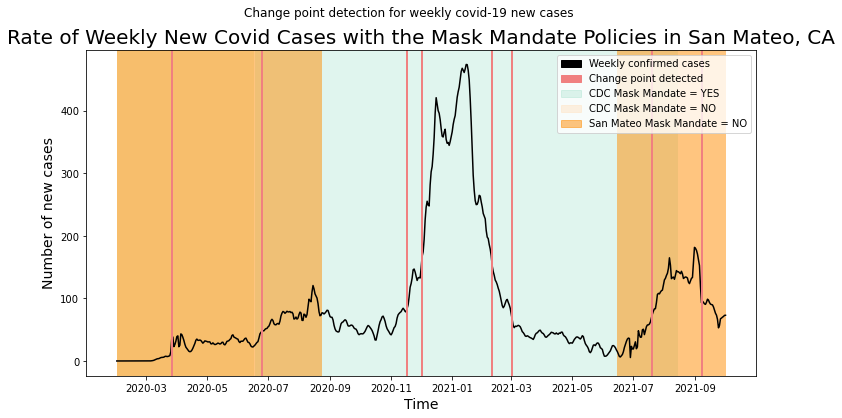

In [52]:
# Using the ruptures package for detecting change point
# Pelt Search Method for number of new covid cases in San Mateo County

data = np.array(county_cases_bydate)
algo = rpt.Pelt(model="rbf").fit(data)

change_locations = algo.predict(pen=10)
change_locations = county_cases_bydate.iloc[change_locations[:-1]].index.to_list()

plt.figure(figsize=(12,6))
plt.plot(county_cases_bydate, color = 'black')

# Plotting red horizontal lines for days when a change point is detected
for i in change_locations:
    plt.axvline(i,lw=2, color='lightcoral')
    
red_patch = mpatches.Patch(color='lightcoral', label='Change point detected')
blue_patch = mpatches.Patch(color='black', label='Weekly confirmed cases')

# -------------------------------------------------------------------------------------------
# Adding titles and labels for the visualization    
plt.title('Rate of Weekly New Covid Cases with the Mask Mandate Policies in San Mateo, CA', 
          fontdict = {'fontsize' : 20})
plt.suptitle('Change point detection for weekly covid-19 new cases ', 
          fontdict = {'fontsize' : 20})
plt.xlabel('Time', fontsize=14)
plt.ylabel('Number of new cases', fontsize=14)

# -------------------------------------------------------------------------------------------
# As per CDC data
# lighter green background = Mask mandate is YES
# from the dataframe above 'm_mandate_county'

plt.axvspan('2020-06-18', '2021-08-15', facecolor='mediumaquamarine', alpha=0.2)
lgreen_patch = mpatches.Patch(color='mediumaquamarine', alpha=0.2, label='CDC Mask Mandate = YES')

# From the CDC data in the dataframe 'm_mandate_county' and from the internet that prior to 
# the start of 4/10/20 there was no mask mandate.
# pink background = Mask Mandate is NO

# San Mateo no mask rule until Aug 24
plt.axvspan('2020-02-01', '2020-08-24', facecolor='darkorange', alpha=0.5)



plt.axvspan('2020-02-01', '2020-06-17', facecolor='goldenrod', alpha=0.2)
gold_patch = mpatches.Patch(color='goldenrod', alpha=0.2, label='CDC Mask Mandate = NO')
# -------------------------------------------------------------------------------------------
# Using government website notice on the current mask mandate (As the CDC data is limited)
# We see from the below source that as of June 15, 2021 - NO MASK MANDATE
# source: smcgoc.org
# link: https://www.smcgov.org/san-mateo-county-reopening

plt.axvspan('2021-06-15', '2021-10-01', facecolor='darkorange', alpha=0.5)
lcoral_patch = mpatches.Patch(color='darkorange', alpha=0.5, label='San Mateo Mask Mandate = NO')

# -------------------------------------------------------------------------------------------
# Passing all the patches arguments to the legend parameter
plt.legend(handles=[blue_patch, red_patch, lgreen_patch, lpink_patch, lcoral_patch])


**Inference** : The second wave in the covid cases after May 2021 can be attributed to the fact that the San Mateo county lifted the masking mandates. Previously with just the CDC masking mandate, this trend isn't visible. 


## 2. Extension Analysis: What other trends can the masking mandate by the San Mateo County reveal about the pandemic?


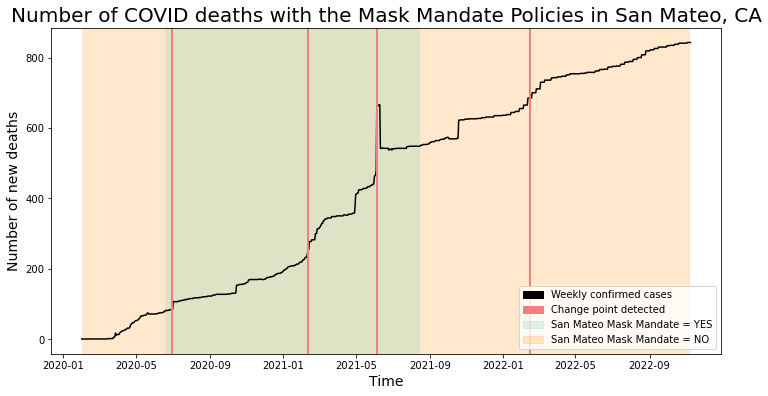

In [46]:
# Using the ruptures package for detecting change point
# Pelt Search Method for covid deaths dataset

data = np.array(df_deaths)
algo = rpt.Pelt(model="rbf").fit(data)

change_locations = algo.predict(pen=10)
change_locations = df_deaths.iloc[change_locations[:-1]].index.to_list()

plt.figure(figsize=(12,6))
plt.plot(df_deaths, color = 'black')

# Plotting red horizontal lines for days when a change point is detected
for i in change_locations:
    plt.axvline(i,lw=2, color='lightcoral')
    
red_patch = mpatches.Patch(color='lightcoral', label='Change point detected')
blue_patch = mpatches.Patch(color='black', label='Weekly confirmed cases')

# -------------------------------------------------------------------------------------------
# Adding titles and labels for the visualization    
plt.title('Number of COVID deaths with the Mask Mandate Policies in San Mateo, CA', 
          fontdict = {'fontsize' : 20})

plt.xlabel('Time', fontsize=14)
plt.ylabel('Number of new deaths', fontsize=14)

plt.axvspan('2020-02-01', '2021-08-15', facecolor='darkorange', alpha=0.2)
no_patch = mpatches.Patch(color='darkorange', alpha=0.2, label='San Mateo Mask Mandate = NO')

plt.axvspan('2020-06-18', '2021-08-15', facecolor='mediumaquamarine', alpha=0.2)
yes_patch = mpatches.Patch(color='mediumaquamarine', alpha=0.2, label='San Mateo Mask Mandate = YES')

plt.axvspan('2021-08-15', '2022-11-08', facecolor='darkorange', alpha=0.2)

plt.legend(handles=[blue_patch, red_patch, yes_patch, no_patch])

**Inference**: The visualization does not really give an indication if the masking mandates are helping with the number of death rates. As we can see, the number of deaths are reducing when the masking mandate isn't enforced. There must be some other external data responsible for this. 

## 3. With every stage of vaccines administered, is there a decrease in the number of deaths caused by COVID?

The below data is not available as a dataset but is found in the articles listed in the datasource mentioned in Step 0 from the San Mateo Health website. 

In [245]:
# Percentage of Vaccines administered in San Mateo County

# 8/1/2020 to 1/31/2021 -- 10% Vaccinated
# 8/1/2020 to 3/16/2021 - 25% vaccinated
# 8/1/2020 to 5/10/2021 - 50% vaccinated
# 8/1/2020 to 7/1/2021 - 75% vaccinated
# 8/1/2020 to 8/1/2021 - 80% vaccinated
# 8/1/2020 to 2/2/2022 - 90% vaccinated

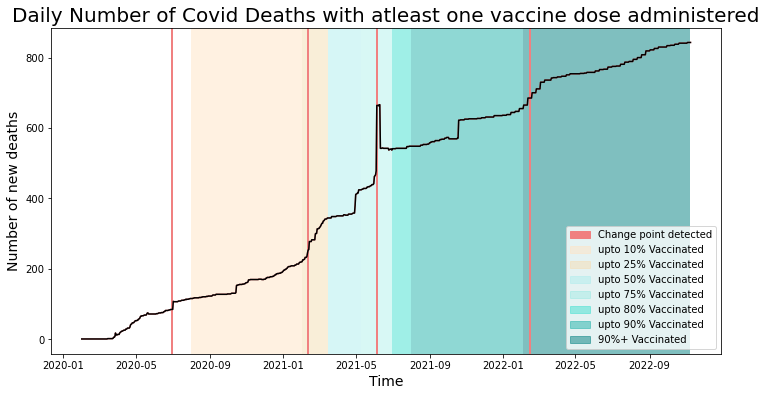

In [54]:
# Plotting the trend line of daily covid related deaths and implementing the change detected algorithm

data = np.array(df_deaths)
algo = rpt.Pelt(model="rbf").fit(data)

change_locations = algo.predict(pen=10)
change_locations = df_deaths.iloc[change_locations[:-1]].index.to_list()

plt.figure(figsize=(12,6))
plt.plot(df_deaths, color = 'lightcoral')

# Plotting red horizontal lines for days when a change point is detected

for i in change_locations:
    plt.axvline(i,lw=2, color='lightcoral')
    
red_patch = mpatches.Patch(color='lightcoral', label='Change point detected')

plt.plot(df_deaths, color = 'black')

blue_patch = mpatches.Patch(color='black', label='Daily Death cases')

# -------------------------------------------------------------------------------------------
# Adding titles and labels for the visualization    
plt.title('Daily Number of Covid Deaths with atleast one vaccine dose administered', 
          fontdict = {'fontsize' : 20})
plt.xlabel('Time', fontsize=14)
plt.ylabel('Number of new deaths', fontsize=14)

# -------------------------------------------------------------------------------------------

plt.axvspan('2020-08-01', '2021-01-31', facecolor='bisque', alpha=0.5)
ten_patch = mpatches.Patch(color='bisque', alpha=0.5, label='upto 10% Vaccinated')

plt.axvspan('2021-01-31', '2021-03-16', facecolor='wheat', alpha=0.5)
twentyfive_patch = mpatches.Patch(color='wheat', alpha=0.5, label='upto 25% Vaccinated')

plt.axvspan('2021-03-16', '2021-05-10', facecolor='paleturquoise', alpha=0.5)
fifty_patch = mpatches.Patch(color='paleturquoise', alpha=0.5, label='upto 50% Vaccinated')

plt.axvspan('2021-05-10', '2021-07-01', facecolor='turquoise', alpha=0.2)
seventyfive_patch = mpatches.Patch(color='turquoise', alpha=0.2, label='upto 75% Vaccinated')

plt.axvspan('2021-07-01', '2021-08-01', facecolor='turquoise', alpha=0.5)
eighty_patch = mpatches.Patch(color='turquoise', alpha=0.5, label='upto 80% Vaccinated')

plt.axvspan('2021-08-01', '2022-02-02', facecolor='lightseagreen', alpha=0.5)
ninety_patch = mpatches.Patch(color='lightseagreen', alpha=0.5, label='upto 90% Vaccinated')

plt.axvspan('2022-02-02', '2022-11-08', facecolor='teal', alpha=0.5)
ninetyp_patch = mpatches.Patch(color='teal', alpha=0.5, label='90%+ Vaccinated')

# -------------------------------------------------------------------------------------------
# Passing all the patches arguments to the legend parameter
plt.legend(handles=[red_patch, ten_patch, twentyfive_patch, fifty_patch, seventyfive_patch, eighty_patch,
                   ninety_patch, ninetyp_patch])

**Inference**: As we can see the rate of which the death toll is rising reduces once the percentage of vaccines being administered crosses the 50%+ threshold. This can be udnerstood from the visualization by noting the reduction in the number of change points detected in before and after the 50%+ vaccinated line. 

## 4. Hypothesis: There is no relationship between the median listing prices of houses and the number of confirmed COVID cases in San Mateo County. 

We shall conduct a welch's t-test to conduct the hypothesis testing. 
The null hypothesis being that the pandemic had no effect of the housing rates. To reject this null hypothesis we must get a p value < 0.05

In [55]:
# Creating two groups of data with unequal variances thus Welch's T-test
group1 = housing_price_pre['h_rate']
group2 = housing_price_post['h_rate']
ttest_ind(group1, group2, equal_var=False)

Ttest_indResult(statistic=0.317006799601606, pvalue=0.7531046651139912)

**NOTE**: If the assumption of the data being normally distributed holds true then, 

The p-value is not significant hence we cannot reject the Null hypothesis. Thus housing prices are not affected due to the pandemic. Although the t-test assumption may not hold true, this resut is valid and the same when we plot the number of covid cases and the housing rate as well. 

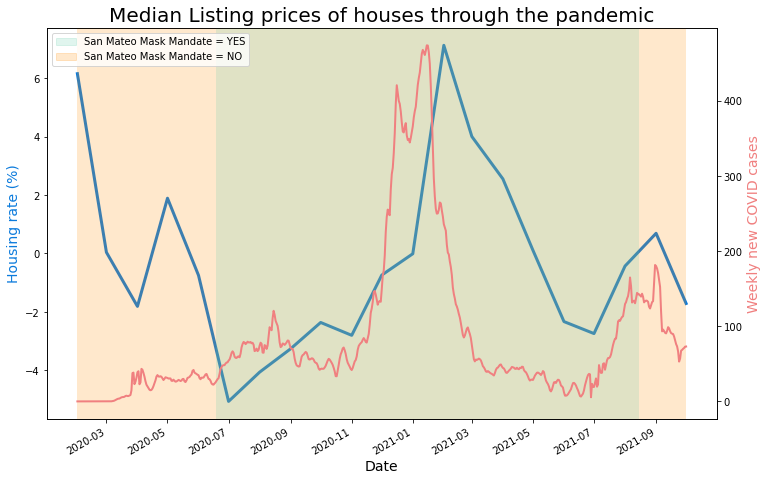

In [61]:
# Creating a dual axis line graph to plot
# Number of weekly covid cases
# v/s Housing rate 

fig, ax1 = plt.subplots(figsize=(12, 8))
ax2 = ax1.twinx()

ax1.plot(housing_price_post['date'], housing_price_post['h_rate'], color ='#0C7BDC', lw=3)
ax2.plot(county_cases_df['date'], county_cases_df['confirmed_cases'], color = 'lightcoral', lw=2);

plt.title("Median Listing prices of houses through the pandemic", fontsize=20)
ax1.set_xlabel("Date", fontsize = 14)
ax1.set_ylabel("Housing rate (%)", color='#0C7BDC', fontsize = 14)
ax2.set_ylabel("Weekly new COVID cases", color='lightcoral', fontsize = 14)

plt.axvspan('2020-02-01', '2021-08-15', facecolor='darkorange', alpha=0.2)
no_patch = mpatches.Patch(color='darkorange', alpha=0.2, label='San Mateo Mask Mandate = NO')

plt.axvspan('2020-06-18', '2021-08-15', facecolor='mediumaquamarine', alpha=0.2)
yes_patch = mpatches.Patch(color='mediumaquamarine', alpha=0.2, label='San Mateo Mask Mandate = YES')

plt.axvspan('2021-08-15', '2021-10-01', facecolor='darkorange', alpha=0.2)

plt.legend(handles=[yes_patch, no_patch])

fig.autofmt_xdate()

**Inference**: From the visualization it is clear that there is no trend of the housing prices being affected by the pandemic. Infact it has been noisy and random. 

## 5. How was the unemployment rate affected in San Mateo County due to the pandemic?

We shall conduct a welch's t-test to conduct the hypothesis testing. 
The null hypothesis being that the pandemic had no effect on the unemployment rates. To reject this null hypothesis we must get a p value < 0.05

In [60]:
group1 = unemp_rate_pre['u_rate']
group2 = unemp_rate_post['u_rate']
ttest_ind(group1, group2, equal_var=False)

Ttest_indResult(statistic=-7.082045904222257, pvalue=6.780189620910947e-07)

**NOTE**: If the assumption of the data being normally distributed holds true then, 

The p-value is significant hence we can reject the Null hypothesis. Thus employment rates are affected due to the pandemic. Although the t-test assumption may not hold true, this resut is valid and the same when we plot the number of covid cases and the unemployment rate as well. 

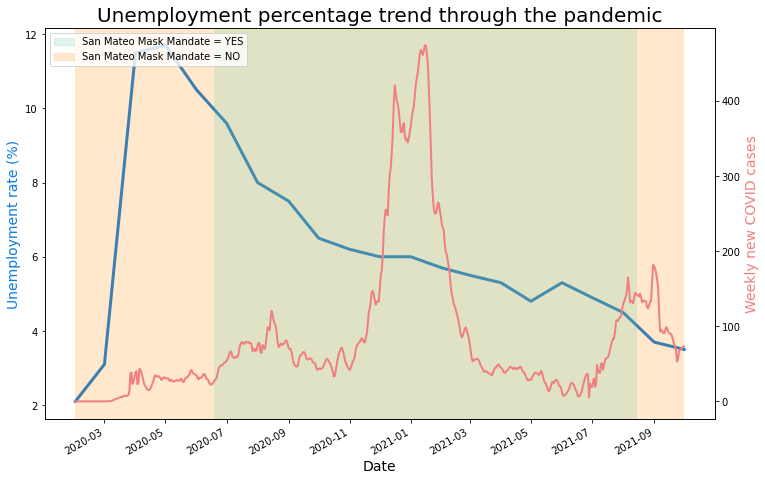

In [62]:
# Creating a dual axis line graph to plot
# Number of weekly covid cases
# v/s Unemployment rate 

fig, ax1 = plt.subplots(figsize=(12, 8))
ax2 = ax1.twinx()

ax1.plot(unemp_rate_post['date'], unemp_rate_post['u_rate'], color ='#0C7BDC', lw=3)
ax2.plot(county_cases_df['date'], county_cases_df['confirmed_cases'], color = 'lightcoral', lw=2);

plt.title("Unemployment percentage trend through the pandemic", fontsize=20)
ax1.set_xlabel("Date", fontsize = 14)
ax1.set_ylabel("Unemployment rate (%)", color='#0C7BDC', fontsize = 14)
ax2.set_ylabel("Weekly new COVID cases", color='lightcoral', fontsize = 14)

plt.axvspan('2020-02-01', '2021-08-15', facecolor='darkorange', alpha=0.2)
no_patch = mpatches.Patch(color='darkorange', alpha=0.2, label='San Mateo Mask Mandate = NO')

plt.axvspan('2020-06-18', '2021-08-15', facecolor='mediumaquamarine', alpha=0.2)
yes_patch = mpatches.Patch(color='mediumaquamarine', alpha=0.2, label='San Mateo Mask Mandate = YES')

plt.axvspan('2021-08-15', '2021-10-01', facecolor='darkorange', alpha=0.2)

plt.legend(handles=[yes_patch, no_patch])

fig.autofmt_xdate()

**Inference**: During the start of the pandemic the unemployment levels rose sharply, after that the unemployment rates have only been declining. This is a good sign for the people in San Mateo.